In [122]:
import os
import torch
import numpy as np
from dataset import ModelNet40, collate_fn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [123]:
def plot_pcu(vector):
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    xdata = vector[:, 0]
    ydata = vector[:, 1]
    zdata = vector[:, 2]
    
    ax.scatter3D(xdata, ydata, zdata, cmap='Greens')
    plt.show()

## Dataset Path

In [137]:

print(os.getcwd())

modelnet40_path = os.path.join(os.getcwd(), 'ModelNet40')
print(modelnet40_path)
SAMPLE_SIZE = 2048
TEST = False
SAMPLING_METHOD = 'uni-sph'
batch_size = 16

/home/arrow/Desktop/University Materials/COMP 399/Research
/home/arrow/Desktop/University Materials/COMP 399/Research/ModelNet40


## Dataset Instance

In [138]:
dataset = ModelNet40(dataset_path=modelnet40_path, test=TEST, sample_size=SAMPLE_SIZE, sampling=SAMPLING_METHOD)

In [139]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [140]:
points = None
labels = None
counter = 0
for (d,s, l) in data_loader:
    if counter == 1:
        break
    counter +=1
    labels = s
    points = d

In [141]:
print(points[1].shape, labels)

torch.Size([2048, 3]) tensor([32, 29, 28, 33])


## Test Shuffle

In [142]:
def shuffle_data(data, labels):
    """ Shuffle data and labels.
        Input:
          data: B,N,... numpy array
          label: B,... numpy array
        Return:
          shuffled data, label and shuffle indices
    """
    idx = np.arange(len(labels))
    np.random.shuffle(idx)
    return data[idx, ...], labels[idx], idx

In [143]:
shuffled_data, shuffled_labels, indices = shuffle_data(points.numpy(), labels.numpy())

## Test Rotation

In [144]:
def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def rotate_point_cloud_with_normal(batch_xyz_normal):
    ''' Randomly rotate XYZ, normal point cloud.
        Input:
            batch_xyz_normal: B,N,6, first three channels are XYZ, last 3 all normal
        Output:
            B,N,6, rotated XYZ, normal point cloud
    '''
    for k in range(batch_xyz_normal.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_xyz_normal[k,:,0:3]
        shape_normal = batch_xyz_normal[k,:,3:6]
        batch_xyz_normal[k,:,0:3] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
        batch_xyz_normal[k,:,3:6] = np.dot(shape_normal.reshape((-1, 3)), rotation_matrix)
    return batch_xyz_normal

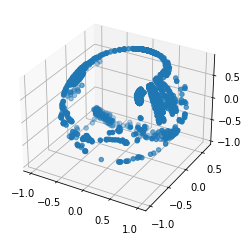

In [145]:
plot_pcu(points[0])

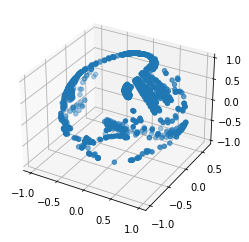

In [146]:
r = rotate_point_cloud(points)
plot_pcu(r[0])